In [1]:
import argparse
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import skimage
import tifffile
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from skimage import exposure

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "G4-1"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
if in_notebook:
    return_dict = read_in_channels(
        find_files_available(input_dir),
        channel_dict={
            "nuclei": "405",
            "cyto1": "488",
            "cyto2": "555",
            "cyto3": "640",
            "brightfield": "TRANS",
        },
        channels_to_read=["cyto2"],
    )
    cyto2_raw = return_dict["cyto2"]
cell_mask_path = pathlib.Path(f"{mask_path}/cell_mask.tiff")
cell_mask = read_zstack_image(cell_mask_path)

/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.11/site-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int32 to uint16 without scaling because max value 9 fits in uint16
  return _convert(image, np.uint16, force_copy)


In [7]:
# convert the cell masks to binary masks
cell_binary_mask = cell_mask.copy()
cell_binary_mask[cell_binary_mask > 0] = 1
# dilate the cell masks slightly
cell_binary_mask = skimage.morphology.binary_dilation(
    cell_binary_mask, skimage.morphology.ball(2)
)
# fill holes
cell_binary_mask = skimage.morphology.binary_closing(
    cell_binary_mask, skimage.morphology.ball(2)
)
# remove small objects
cell_binary_mask = skimage.morphology.remove_small_objects(
    cell_binary_mask.astype(bool), min_size=300
)
# convert back to instance mask
# make sure each instance has a unique integer label
organoid_masks = skimage.measure.label(cell_binary_mask)

In [7]:
# save the organoid masks
organoid_mask_output_path = pathlib.Path(f"{mask_path}/organoid_mask.tiff").resolve()
tifffile.imwrite(organoid_mask_output_path, organoid_masks.astype(np.uint16))

In [8]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")


    Memory and time profiling for the run:

    Memory usage: 965.89 MB

    Time:

    --- %s seconds --- % 31.582078218460083

    --- %s minutes --- % 0.526367970307668

    --- %s hours --- % 0.0087727995051278



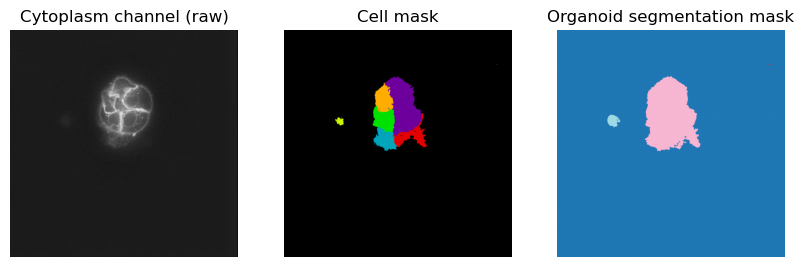

In [9]:
if in_notebook:
    cyto2_raw = exposure.equalize_adapthist(cyto2_raw, clip_limit=0.02)
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(cyto2_raw[cyto2_raw.shape[0] // 2], cmap="gray")
    plt.axis("off")
    plt.title("Cytoplasm channel (raw)")
    plt.subplot(132)
    plt.imshow(cell_mask[cell_mask.shape[0] // 2], cmap="nipy_spectral")
    plt.axis("off")
    plt.title("Cell mask")
    plt.subplot(133)
    plt.imshow(organoid_masks[organoid_masks.shape[0] // 2], cmap="tab20")
    plt.axis("off")
    plt.title("Organoid segmentation mask")
    plt.show()